# Section 5. Prediction on Risks

In this section, we are going to use the word2vec model trainned by the corpus to performing the word embedding for the texts we are interested in.

In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

## 5.1 Labeled Dataset

### 5.1.1 Insight

In [2]:
risk_df = pd.read_csv("../Section 3 - Risk Factor Organizing/risk.csv")
selectedColumns = ["adsh", "Risk Factors", "Label 1"]
risk_df = risk_df[selectedColumns]
risk_df.head()

,adsh,Risk Factors,Label 1
0,0000036966-23-000016,Risks Related to the Pending TD Merger,strategy risk
1,0000036966-23-000016,Receipt of regulatory approvals for the Pendin...,strategy risk
2,0000036966-23-000016,"Regulatory approvals may not be received, have...",legal and regulatory risk
3,0000036966-23-000016,The TD Merger Agreement may be terminated in a...,strategy risk
4,0000036966-23-000016,Failure to complete the Pending TD Merger coul...,market risk


In [3]:
_22FY10KFile_df = pd.read_csv("../Section 1 - Datasets Downloads and Preparation/22FY10KFile.csv")
_22FY10KFile_df.head()

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,accepted,prevrpt,detail,instance,nciks,aciks,SIC Code,Office,Industry Title,filing_url
0,0001412408-22-000019,1412408,"PHREESIA, INC.",7389.0,US,NC,RALEIGH,27601,434 FAYETTEVILLE ST.,SUITE 1400,...,2022-03-31 16:03:00.0,0,1,phr-20220131_htm.xml,1,NaN,7389,Office of Trade & Services,"SERVICES-BUSINESS SERVICES, NEC",https://www.sec.gov/Archives/edgar/data/141240...
1,0001428336-22-000009,1428336,"HEALTHEQUITY, INC.",7389.0,US,UT,DRAPER,84020,15 WEST SCENIC POINTE DRIVE,SUITE 100,...,2022-03-31 16:04:00.0,0,1,hqy-20220131_htm.xml,1,NaN,7389,Office of Trade & Services,"SERVICES-BUSINESS SERVICES, NEC",https://www.sec.gov/Archives/edgar/data/142833...
2,0001199835-22-000283,1079282,"RIVULET MEDIA, INC.",7389.0,US,AZ,GILBERT,85296,"1206 EAST WARNER ROAD, SUITE 101-I",NaN,...,2022-05-12 20:06:00.0,0,1,rivu-10k_htm.xml,1,NaN,7389,Office of Trade & Services,"SERVICES-BUSINESS SERVICES, NEC",https://www.sec.gov/Archives/edgar/data/107928...
3,0001558891-22-000031,1726079,"TIPMEFAST, INC.",7389.0,IL,NaN,ZIHRON YA'AKOV,30950,HASHUMURA ST 1,NaN,...,2022-05-13 11:56:00.0,0,1,tpmf-20211231_htm.xml,1,NaN,7389,Office of Trade & Services,"SERVICES-BUSINESS SERVICES, NEC",https://www.sec.gov/Archives/edgar/data/172607...
4,0001493152-22-009370,1022899,"PROTAGENIC THERAPEUTICS, INC.NEW",7389.0,US,NY,NEW YORK,10010,149 FIFTH AVENUE,SUITE 500,...,2022-04-07 17:09:00.0,0,1,form10-k_htm.xml,1,NaN,7389,Office of Trade & Services,"SERVICES-BUSINESS SERVICES, NEC",https://www.sec.gov/Archives/edgar/data/102289...


In [4]:
risk_df = pd.merge(risk_df, _22FY10KFile_df, left_on = "adsh", right_on = "adsh")
risk_df.head()

,adsh,Risk Factors,Label 1,cik,name,sic,countryba,stprba,cityba,zipba,...,accepted,prevrpt,detail,instance,nciks,aciks,SIC Code,Office,Industry Title,filing_url
0,0000036966-23-000016,Risks Related to the Pending TD Merger,strategy risk,36966,FIRST HORIZON CORP,6021.0,US,TN,MEMPHIS,38103,...,2023-03-01 06:07:00.0,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...
1,0000036966-23-000016,Receipt of regulatory approvals for the Pendin...,strategy risk,36966,FIRST HORIZON CORP,6021.0,US,TN,MEMPHIS,38103,...,2023-03-01 06:07:00.0,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...
2,0000036966-23-000016,"Regulatory approvals may not be received, have...",legal and regulatory risk,36966,FIRST HORIZON CORP,6021.0,US,TN,MEMPHIS,38103,...,2023-03-01 06:07:00.0,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...
3,0000036966-23-000016,The TD Merger Agreement may be terminated in a...,strategy risk,36966,FIRST HORIZON CORP,6021.0,US,TN,MEMPHIS,38103,...,2023-03-01 06:07:00.0,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...
4,0000036966-23-000016,Failure to complete the Pending TD Merger coul...,market risk,36966,FIRST HORIZON CORP,6021.0,US,TN,MEMPHIS,38103,...,2023-03-01 06:07:00.0,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...


In [5]:
risk_df.to_csv("risk.csv", index=False)

### 5.1.2 EDA

We plot the number of different risk factors in this dataset. It shows that the most common risk is operational risk, and the least common one is the competition risk.

<Axes: title={'center': 'Number of Risk Factors'}, xlabel='Label 1'>

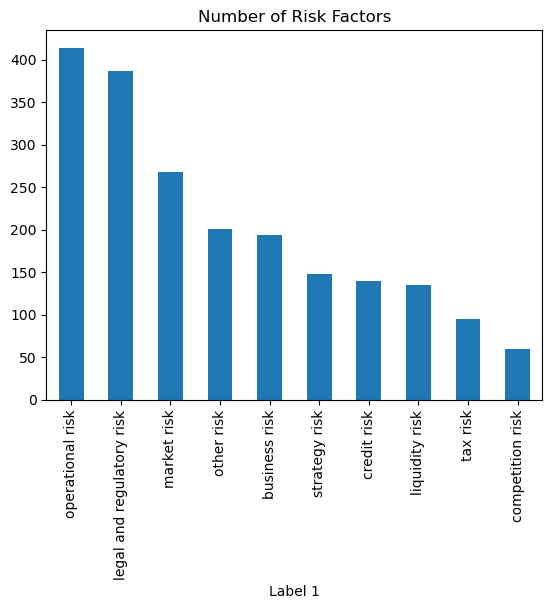

In [6]:
risk_df["Label 1"].value_counts().plot(kind="bar", title="Number of Risk Factors")

Variable "afs" represents the file status. For those large company, SEC requires them to submit the financial report more frequently. Therefore, we plot the number of different file status to understand the company scales. From the result, afs of 1-LAF means large company, which is the most section in our dataset. 

<Axes: title={'center': 'File Status'}, xlabel='afs'>

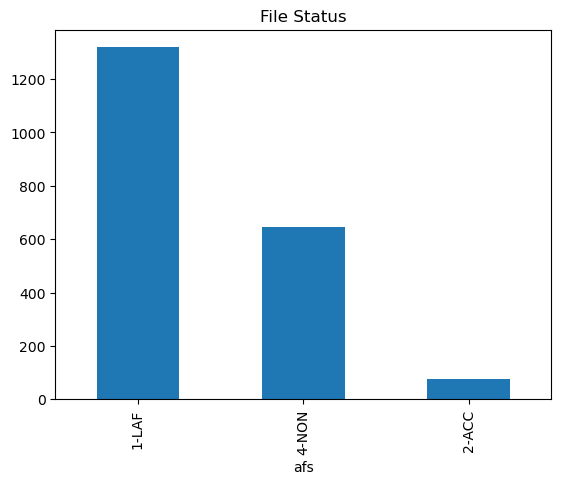

In [7]:
risk_df["afs"].value_counts().plot(kind="bar", title="File Status")

We plot the number of records in different industries.

<Axes: title={'center': 'Number of records in different Industries'}, xlabel='Office'>

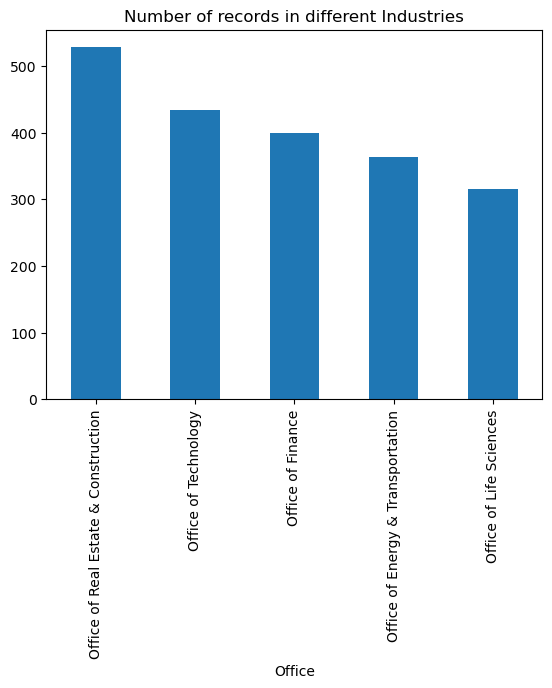

In [8]:
risk_df["Office"].value_counts().plot(kind="bar", title="Number of records in different Industries")

For different company scale, the risk factors are quite different. We see that operational risk is the most frequently category in large company. But in the small company (4-Non), the most frequently risk facotr is the legal and regulatory risk.

(array([0, 1, 2]),
 [Text(0, 0, '1-LAF'), Text(1, 0, '4-NON'), Text(2, 0, '2-ACC')])

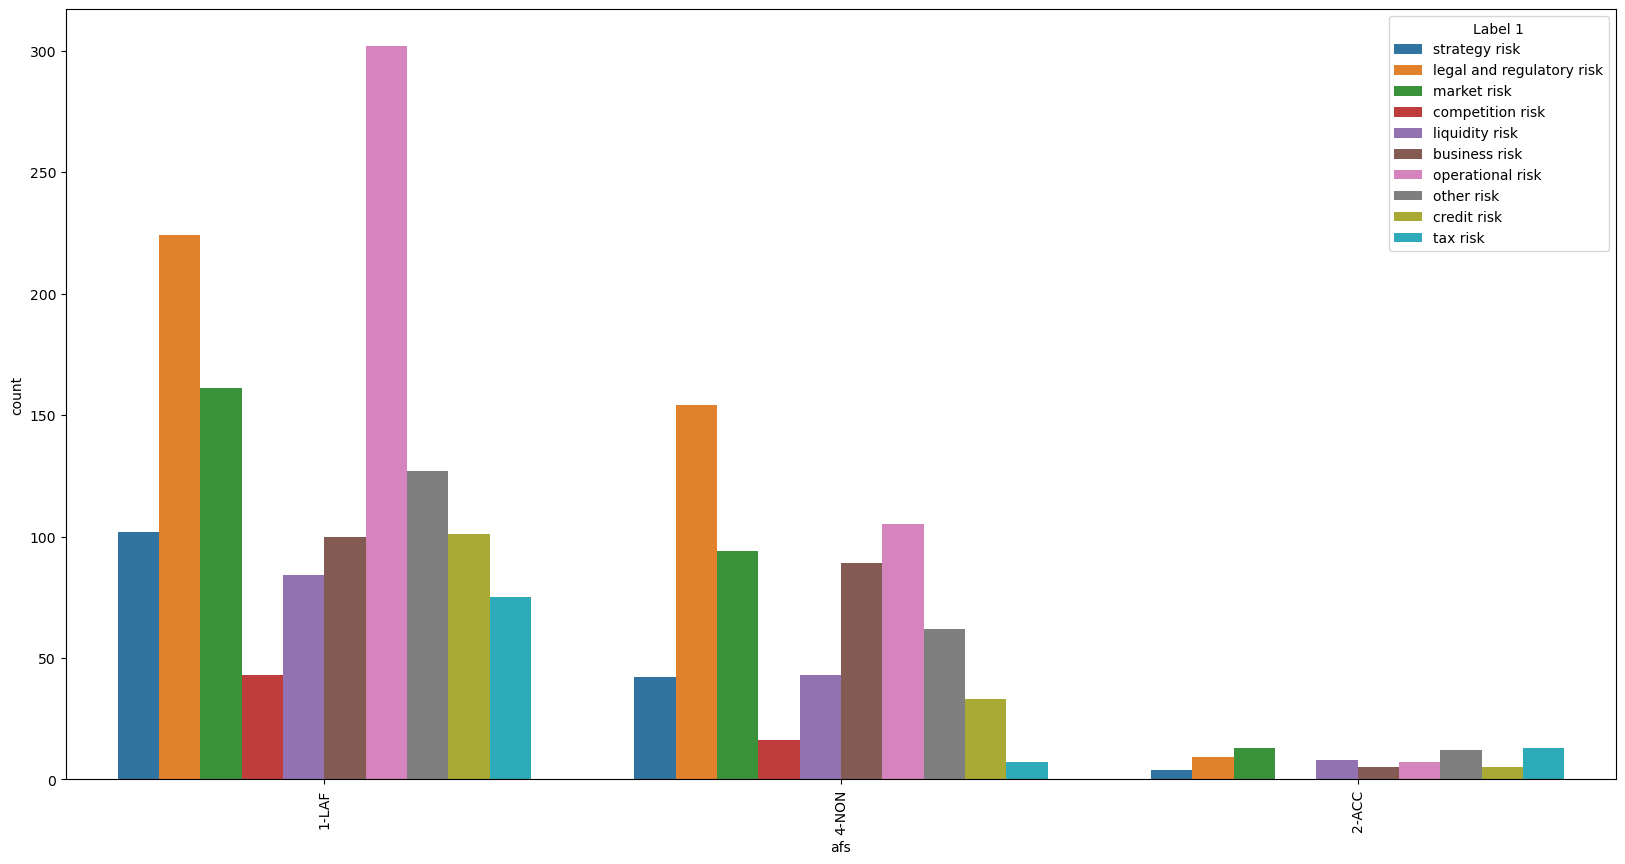

In [9]:
plt.figure(figsize=(20,10))
sns.countplot(x='afs', hue='Label 1', data=risk_df)
plt.xticks(rotation=90)

Similarly, the categories of risk in different industries are quite different. For instance, the real estate industry has a highest frequncy in operational risks but life sciences intrustry has a highest frequency in legal and regulatory risk. This is reasonable because the life sciences industry is subject to increasingly stringent laws and regulations due to the potential risks to public health associated with the misuse of drugs, biological experiments, and the like, while the real estate industry may incur significant losses due to improper operations.

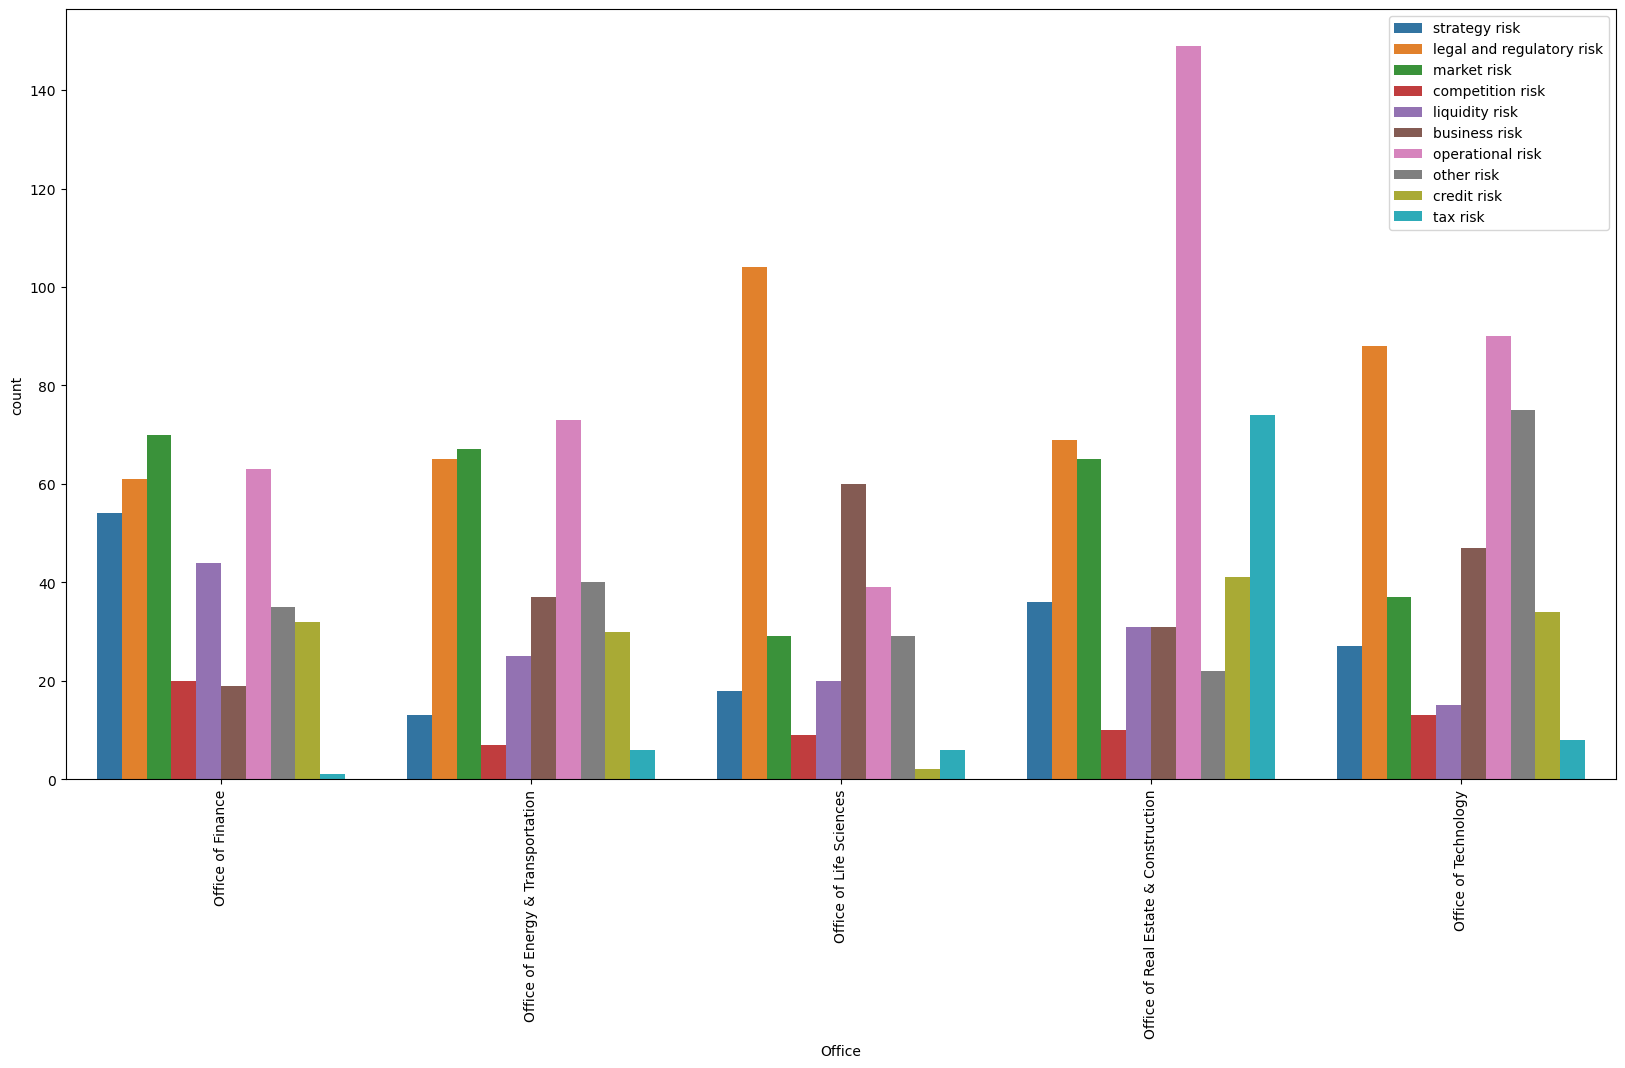

In [10]:
plt.figure(figsize=(20,10))
sns.countplot(x='Office', hue='Label 1', data=risk_df)
plt.xticks(rotation=90)
plt.legend(loc='upper right')

---

## 5.2 Corpus Pre-processing

### 5.2.1 Risk Factors Corpus
 We have build up a corpus based on the text collected from SEC website. Now, we are going to attempt it for our word2vec model.
1. Read in the corpus dataset

In [11]:
riskCorpus_df = pd.read_csv("../Section 4 - Corpus/Corpus.csv")
riskCorpus_df.head()

,adsh,Risk Factors
0,0000004904-23-000011,GENERAL RISKS OF REGULATED OPERATIONS
1,0000004904-23-000011,"RISKS RELATED TO MARKET, ECONOMIC OR FINANCIAL..."
2,0000004904-23-000011,Physical attacks or hostile cyber intrusions c...
3,0000004904-23-000011,RISKS RELATED TO OWNING AND OPERATING GENERATI...
4,0000007332-23-000005,"Natural gas, oil and NGL prices and basis diff..."


In [12]:
riskCorpus_lst = riskCorpus_df["Risk Factors"].tolist()
print("The first 5 records in the file are shown below: \n", riskCorpus_lst[:5], "\n")
print("There are", len(riskCorpus_lst), "records in the file.")

The first 5 records in the file are shown below: 
 ['GENERAL RISKS OF REGULATED OPERATIONS', 'RISKS RELATED TO MARKET, ECONOMIC OR FINANCIAL VOLATILITY AND OTHER RISKS', 'Physical attacks or hostile cyber intrusions could severely impair operations, lead to the disclosure of confidential', 'RISKS RELATED TO OWNING AND OPERATING GENERATION ASSETS AND SELLING POWER', 'Natural gas, oil and NGL prices and basis differentials greatly affect our revenues and thus profits, liquidity, growth, ability to repay our debt and the value of our assets.'] 

There are 89001 records in the file.


2. To train a word2vec model, we firstly need to tokenize the corpus. Basically, we only focus on the English words without any punctuations and remove the stopwords. Also, we stem the tokens.

In [13]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("risk")
stopwords.append("risks")
print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 181 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [14]:
from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer 
stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)
            
#     # stemming
#     stems = [stemmer.stem(t) for t in filtered_tokens]

    return filtered_tokens
#     return stems

3. Now, we output a few results of records in the corpus.

In [15]:
corpusToken_lst = []
for i in range(0,len(riskCorpus_df)):
    corpusToken_lst.append(tokenization_and_stemming(riskCorpus_lst[i]))
print("The token of the first 5 text are shown below: \n", corpusToken_lst[:5], "\n")
print("There are", len(corpusToken_lst), "elements in the token list.")

The token of the first 5 text are shown below: 
 [['general', 'regulated', 'operations'], ['related', 'market', 'economic', 'financial', 'volatility'], ['physical', 'attacks', 'hostile', 'cyber', 'intrusions', 'could', 'severely', 'impair', 'operations', 'lead', 'disclosure', 'confidential'], ['related', 'owning', 'operating', 'generation', 'assets', 'selling', 'power'], ['natural', 'gas', 'oil', 'ngl', 'prices', 'basis', 'differentials', 'greatly', 'affect', 'revenues', 'thus', 'profits', 'liquidity', 'growth', 'ability', 'repay', 'debt', 'value', 'assets']] 

There are 89001 elements in the token list.


4. Count the word frequency.

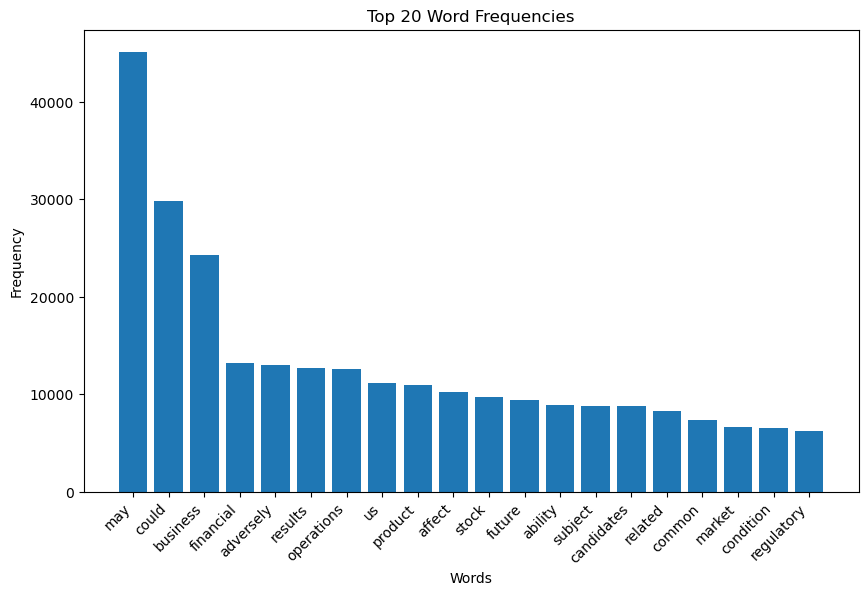

In [16]:
from collections import Counter

flat_words = [word for sublist in corpusToken_lst for word in sublist]
word_counts = Counter(flat_words)
top_words = word_counts.most_common(20)
top_words, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.bar(top_words, counts)
plt.title('Top 20 Word Frequencies')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

## 5.3 Word2vec Model
### 5.3.1 Train word2vec model by risk factor subject corpus
1. After processing the corpus, we start to train the word2vec model.

In [20]:
import gensim
from gensim.models import Word2Vec

w2v_model1 = Word2Vec(corpusToken_lst, vector_size = 100, window = 5, epochs = 10, min_count = 5)

2. model visualization

In [21]:
from sklearn.decomposition import PCA

X = w2v_model1.wv[w2v_model1.wv.key_to_index]
pca = PCA(n_components = 2)
result = pca.fit_transform(X)

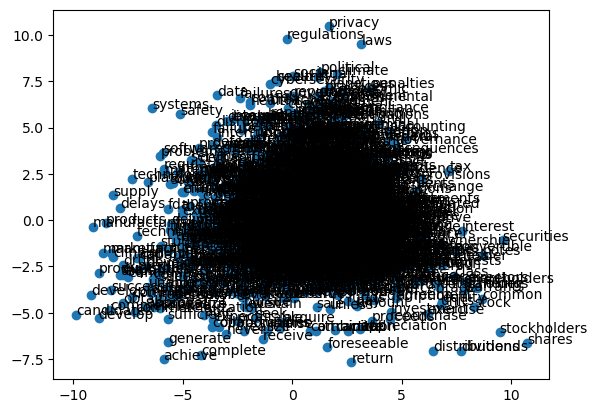

In [22]:
import matplotlib.pyplot as plt

plt.scatter(result[:,0], result[:, 1])
words = list(w2v_model1.wv.key_to_index)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i,0], result[i,1]))
plt.show()

### 5.3.2 Apply word2vec model on labeled dataset

We firstly need to generate a tf-idf matrix for the risk factors in labeled dataset. This tf-idf matrix would be used in transforming the word vector to a sentence vector.

In [23]:
risk_lst = risk_df["Risk Factors"].tolist()

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_TFIDF_matrix(token_lst):
    text_lst = [' '.join(words) for words in token_lst]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(text_lst)
    featureNames = vectorizer.get_feature_names_out()
    dense_matrix = tfidf_matrix.todense()
    return featureNames, dense_matrix

In [25]:
riskToken_lst = []
for i in range(0,len(risk_df)):
    riskToken_lst.append(tokenization_and_stemming(risk_lst[i]))
print("The token of the first 5 text are shown below: \n", riskToken_lst[:5], "\n")
print("There are", len(riskToken_lst), "elements in the token list.")

The token of the first 5 text are shown below: 
 [['related', 'pending', 'td', 'merger'], ['receipt', 'regulatory', 'approvals', 'pending', 'td', 'merger', 'taken', 'longer', 'originally', 'anticipated', 'td', 'expect', 'necessary', 'regulatory', 'approvals', 'received', 'time', 'complete', 'pending', 'td', 'merger', 'current', 'outside', 'date', 'may'], ['regulatory', 'approvals', 'may', 'received', 'taken', 'longer', 'expected', 'may', 'impose', 'conditions', 'presently', 'anticipated'], ['td', 'merger', 'agreement', 'may', 'terminated', 'accordance', 'terms', 'pending', 'td', 'merger', 'may', 'completed'], ['failure', 'complete', 'pending', 'td', 'merger', 'could', 'negatively', 'impact', 'stock', 'price', 'result', 'litigation', 'result', 'significant', 'dilution', 'due', 'terms', 'series', 'g', 'preferred', 'stock', 'issued', 'td']] 

There are 2040 elements in the token list.


In [26]:
featureNames, tfidf_matrix = get_TFIDF_matrix(riskToken_lst)
print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " records and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 2040 records and 2827 terms.


Now, we apply the word2vec model on the risk factors text. For each token in a record, we have a correspongding vector by using the word2vec model. However, what we want to use for prediction is actually a group of words acquired from a sentence. Therefore, we want to use all word vectors in a record to generate a sentence vector. To achieve this, we use the tf-idf of each word we calculated previously as a weight to calculate the weighted average of all word vectors in a sentence as a sentence vector.

In [35]:
avgVector_lst = []
r = 0
for token_lst in riskToken_lst:
    vector_lst = []
    for token in token_lst:
        if token in w2v_model1.wv:
            
            word_idx = np.where(featureNames == token)[0][0] if token in featureNames else 0
            tfidf = tfidf_matrix[r, word_idx]
            vector_lst.append(w2v_model1.wv.get_vector(token)*tfidf)
            
    if not vector_lst:
        avgVector_lst.append([0]*100)
    else:
        avgVector_lst.append((sum(vector_lst) / len(vector_lst)).tolist())
    r+=1        
print("The sentence vector is in shape of", len(avgVector_lst),"*", len(avgVector_lst[0]))

The sentence vector is in shape of 2040 * 100


In [36]:
def find_zero_rows(matrix):
    zero_rows = []

    for i, row in enumerate(matrix):
        if all(element == 0 for element in row):
            zero_rows.append(i)

    return zero_rows

find_zero_rows(avgVector_lst)

[163, 315, 743, 744, 754, 1444]

## 5.4 Models for Prediction
### 5.4.1 Generate a Target Label
Beacause of the labeled dataset is not large enough for a multi-classification task, we have to perform a binary classification on this dataset. Therefore, the first step is to determine the risk that we are interested in and generate the corresponding label as a target variable that we are going to predict. Here, we define a function and use "legal and regulatory risk" as an example to train the model, make a classification and evaluation.

In [37]:
def generate_target_risk(riskName, df):
    df['Target Risk'] = df['Label 1'].apply(lambda x: 1 if x == riskName else 0)
    return df

In [38]:
lrrRisk_df = generate_target_risk(riskName="legal and regulatory risk", df=risk_df)
lrrRisk_df.head()

,adsh,Risk Factors,Label 1,cik,name,sic,countryba,stprba,cityba,zipba,...,prevrpt,detail,instance,nciks,aciks,SIC Code,Office,Industry Title,filing_url,Target Risk
0,0000036966-23-000016,Risks Related to the Pending TD Merger,strategy risk,36966,FIRST HORIZON CORP,6021.0,US,TN,MEMPHIS,38103,...,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...,0
1,0000036966-23-000016,Receipt of regulatory approvals for the Pendin...,strategy risk,36966,FIRST HORIZON CORP,6021.0,US,TN,MEMPHIS,38103,...,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...,0
2,0000036966-23-000016,"Regulatory approvals may not be received, have...",legal and regulatory risk,36966,FIRST HORIZON CORP,6021.0,US,TN,MEMPHIS,38103,...,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...,1
3,0000036966-23-000016,The TD Merger Agreement may be terminated in a...,strategy risk,36966,FIRST HORIZON CORP,6021.0,US,TN,MEMPHIS,38103,...,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...,0
4,0000036966-23-000016,Failure to complete the Pending TD Merger coul...,market risk,36966,FIRST HORIZON CORP,6021.0,US,TN,MEMPHIS,38103,...,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...,0


<Axes: title={'center': 'File Status'}, xlabel='Target Risk'>

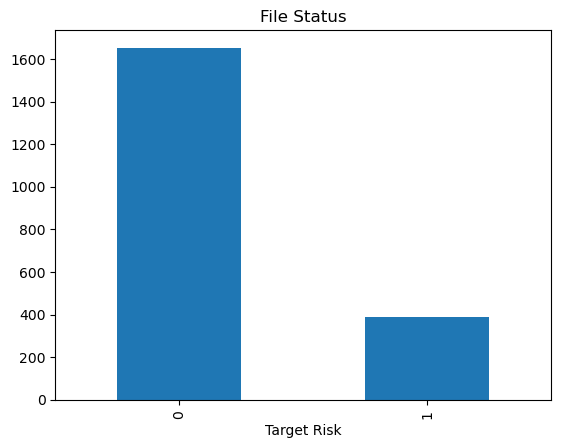

In [39]:
lrrRisk_df["Target Risk"].value_counts().plot(kind="bar", title="File Status")

### 5.4.2 Split the dataset

We define the sentence vector as X and target risk as y and then split the dataset with train size of 0.7.

In [40]:
X = np.array(avgVector_lst)
y = risk_df["Target Risk"].values

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 123, stratify = y)

### 5.4.3 Train models for prediction
Here, we train 3 different models to predict whether a risk subject text is a legal and regulatory risk.
1. Logistic Regression Model:

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
LR_clf = LogisticRegression()
LR_clf = LR_clf.fit(X_train, y_train)
y_pred = LR_clf.predict(X_test)
print("The accuracy of the logistic model is: \n", accuracy_score(y_test, y_pred))

The accuracy of the logistic model is: 
 0.9117647058823529


2. Random Forest Model:

In [43]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(random_state = 123)
RF_clf = RF_clf.fit(X_train, y_train)
y_pred = RF_clf.predict(X_test)
print("The accuracy of the random forest model is: \n", accuracy_score(y_test, y_pred))

The accuracy of the random forest model is: 
 0.9150326797385621


3. Dense Layer Model:

In [44]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(256, activation="relu"))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.fit(X_train, y_train, batch_size=256, epochs=200, verbose=2, validation_data=(X_test, y_test))

Epoch 1/200
6/6 - 1s - loss: 11.8126 - acc: 0.0028 - val_loss: 10.9655 - val_acc: 0.0098 - 518ms/epoch - 86ms/step
Epoch 2/200
6/6 - 0s - loss: 10.4697 - acc: 0.0147 - val_loss: 9.7403 - val_acc: 0.0441 - 46ms/epoch - 8ms/step
Epoch 3/200
6/6 - 0s - loss: 9.1286 - acc: 0.0623 - val_loss: 8.4121 - val_acc: 0.1291 - 47ms/epoch - 8ms/step
Epoch 4/200
6/6 - 0s - loss: 7.7848 - acc: 0.1779 - val_loss: 7.1931 - val_acc: 0.2696 - 42ms/epoch - 7ms/step
Epoch 5/200
6/6 - 0s - loss: 6.5542 - acc: 0.2892 - val_loss: 6.0244 - val_acc: 0.3856 - 46ms/epoch - 8ms/step
Epoch 6/200
6/6 - 0s - loss: 5.5181 - acc: 0.3936 - val_loss: 5.1565 - val_acc: 0.4592 - 46ms/epoch - 8ms/step
Epoch 7/200
6/6 - 0s - loss: 4.6513 - acc: 0.4811 - val_loss: 4.5173 - val_acc: 0.5082 - 46ms/epoch - 8ms/step
Epoch 8/200
6/6 - 0s - loss: 3.9930 - acc: 0.5427 - val_loss: 3.8978 - val_acc: 0.5654 - 41ms/epoch - 7ms/step
Epoch 9/200
6/6 - 0s - loss: 3.4839 - acc: 0.5924 - val_loss: 3.4581 - val_acc: 0.5980 - 45ms/epoch - 8ms/s

Epoch 75/200
6/6 - 0s - loss: 0.9199 - acc: 0.8725 - val_loss: 1.3545 - val_acc: 0.8448 - 41ms/epoch - 7ms/step
Epoch 76/200
6/6 - 0s - loss: 0.9192 - acc: 0.8725 - val_loss: 1.3435 - val_acc: 0.8448 - 38ms/epoch - 6ms/step
Epoch 77/200
6/6 - 0s - loss: 0.9373 - acc: 0.8704 - val_loss: 1.3427 - val_acc: 0.8415 - 40ms/epoch - 7ms/step
Epoch 78/200
6/6 - 0s - loss: 0.9494 - acc: 0.8690 - val_loss: 1.3580 - val_acc: 0.8399 - 39ms/epoch - 6ms/step
Epoch 79/200
6/6 - 0s - loss: 0.9601 - acc: 0.8697 - val_loss: 1.3821 - val_acc: 0.8399 - 40ms/epoch - 7ms/step
Epoch 80/200
6/6 - 0s - loss: 0.9587 - acc: 0.8697 - val_loss: 1.3907 - val_acc: 0.8382 - 40ms/epoch - 7ms/step
Epoch 81/200
6/6 - 0s - loss: 0.9575 - acc: 0.8704 - val_loss: 1.3398 - val_acc: 0.8382 - 38ms/epoch - 6ms/step
Epoch 82/200
6/6 - 0s - loss: 0.9288 - acc: 0.8718 - val_loss: 1.3146 - val_acc: 0.8399 - 39ms/epoch - 6ms/step
Epoch 83/200
6/6 - 0s - loss: 0.9247 - acc: 0.8718 - val_loss: 1.2959 - val_acc: 0.8399 - 40ms/epoch - 7

Epoch 148/200
6/6 - 0s - loss: 0.9944 - acc: 0.8915 - val_loss: 1.4962 - val_acc: 0.8627 - 39ms/epoch - 7ms/step
Epoch 149/200
6/6 - 0s - loss: 0.9873 - acc: 0.8915 - val_loss: 1.4864 - val_acc: 0.8644 - 51ms/epoch - 8ms/step
Epoch 150/200
6/6 - 0s - loss: 0.9917 - acc: 0.8915 - val_loss: 1.4858 - val_acc: 0.8644 - 48ms/epoch - 8ms/step
Epoch 151/200
6/6 - 0s - loss: 0.9924 - acc: 0.8915 - val_loss: 1.4852 - val_acc: 0.8660 - 50ms/epoch - 8ms/step
Epoch 152/200
6/6 - 0s - loss: 0.9955 - acc: 0.8915 - val_loss: 1.4845 - val_acc: 0.8660 - 39ms/epoch - 7ms/step
Epoch 153/200
6/6 - 0s - loss: 0.9949 - acc: 0.8915 - val_loss: 1.4842 - val_acc: 0.8676 - 43ms/epoch - 7ms/step
Epoch 154/200
6/6 - 0s - loss: 0.9943 - acc: 0.8922 - val_loss: 1.4841 - val_acc: 0.8693 - 39ms/epoch - 6ms/step
Epoch 155/200
6/6 - 0s - loss: 0.9937 - acc: 0.8922 - val_loss: 1.4841 - val_acc: 0.8693 - 41ms/epoch - 7ms/step
Epoch 156/200
6/6 - 0s - loss: 0.9939 - acc: 0.8929 - val_loss: 1.4275 - val_acc: 0.8709 - 38ms/

In [45]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 1ms/step - loss: 1.1372 - acc: 0.8693


[1.1371616125106812, 0.8692810535430908]

### 5.4.4 Evaluation
From the result above, we decide to use random forest model to evaluation since it have a good accuracy and not as complex as dense layer model. We plot the confusion matrix and acquire the accuracy, precision, recall and F1 score.

In [46]:
RF_clf = RandomForestClassifier(random_state = 123)
RF_clf = RF_clf.fit(X_train, y_train)
y_pred = RF_clf.predict(X_test)
print("The accuracy of the random forest model is: \n", accuracy_score(y_test, y_pred))

The accuracy of the random forest model is: 
 0.9150326797385621


In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns

# plot confusion matrix
def plot_confusion_matrix(cm):
    confusion_matrix = [[cm[1][1], cm[0][1]], [cm[1][0], cm[0][0]]]
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
          xticklabels=['Positive', 'Nagetive'],
          yticklabels=['Yes', 'No'])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    f1 = 2*precision*recall/(precision+recall)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))
    print ("F1 score is: " + str(f1))

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        plot_confusion_matrix(cm)

Random Forest
Accuracy is: 0.9150326797385621
precision is: 0.9324324324324325
recall is: 0.5948275862068966
F1 score is: 0.7263157894736842


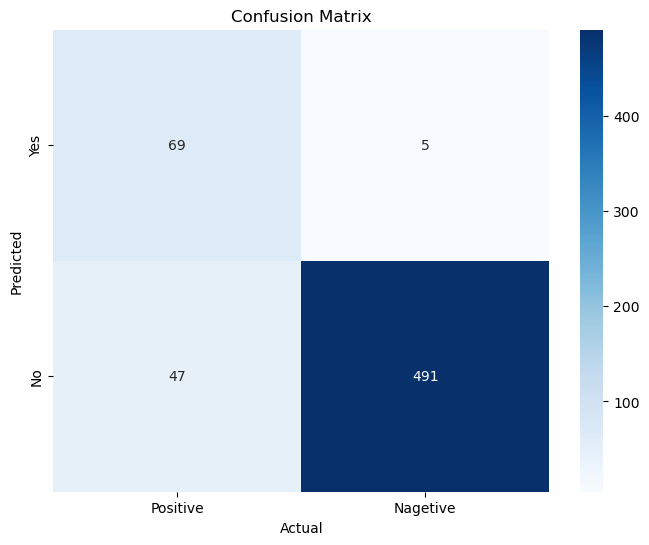

In [48]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [("Random Forest", confusion_matrix(y_test, y_pred))]
draw_confusion_matrices(confusion_matrices)

---

In [49]:
acc_lst = []
for i in range(0, 30):
    RF_clf = RandomForestClassifier(random_state = 123)
    RF_clf = RF_clf.fit(X_train, y_train)
    y_pred = RF_clf.predict(X_test)
    acc_lst.append(accuracy_score(y_test, y_pred))

In [56]:
from scipy import stats

mu_0 = 0.87
alpha = 0.05
t_1, p_1 = stats.ttest_1samp(acc_lst, mu_0, alternative = "less")
if p_1 < alpha:
    print("reject H0.")
else:
    print("retain H0.")

retain H0.


## 5.5 Further Analysis

In [206]:
def train_model(X_train, y_train, modelName):
    if modelName == "Dense Layer":
        model = Sequential()
        model.add(Dense(256, activation="relu"))
        model.add(Dense(10, activation = "softmax"))
        model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
        model.fit(X_train, y_train, batch_size=256, epochs=100, verbose=2, validation_data=(X_test, y_test))
        
    elif modelName == "Random Forest":
        model = RandomForestClassifier(random_state = 123)
        model = model.fit(X_train, y_train)
        
    return model

In [232]:
def get_result(risk_df):
    risk_lst = np.unique(risk_df["Label 1"].values)
    i = 0
    for risk in risk_lst:
        new_df = generate_target_risk(riskName=risk, df=risk_df)
        X = np.array(avgVector_lst)
        y = new_df["Target Risk"].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 123, stratify = y)
        model = train_model(X_train, y_train, modelName = "Random Forest")
        y_pred = model.predict(X_test)
        
        if i == 0:
            predict = y_pred
        else:
            predict = np.vstack([predict, y_pred]) 
        i+=1
                                
    predict = predict.T
    return predict

In [234]:
predict_arr = get_result(risk_df)
print("There are", len(predict_arr), "test records.\n")
print("There are", len(predict_arr[0]), "risks.\n")

There are 585 test records.

There are 10 risks. 

